## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [1]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [3]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [4]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [5]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [6]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [7]:
### YOUR ANSWER HERE
temps = np.arange(3000, 10001, 1000)
bv_colors =[]

for temp in temps:
    m_B = stellar_magnitude(temp, 'B')
    m_V = stellar_magnitude(temp, 'V')
    bv_colors.append(float(m_B - m_V))

print(bv_colors)

[1.0756123643036553, 0.4847465358134224, 0.13254296785128528, -0.09920956796013236, -0.26167031120761974, -0.38079977939034704, -0.471213497832069, -0.5417516702085647]


### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [8]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [9]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

### YOUR ANSWER HERE
def model_magnitudes(temp, A_V, d):
    magnitudes = {}
    for filter in filter_names:
        m_lambda = stellar_magnitude(temp, filter) + 5*np.log10(d/10) + A_V * filters[filter]['R_lambda']
        magnitudes[filter] = float(m_lambda)
    return magnitudes
model_magnitudes(5500, 0.5, 75)

{'B': 11.511958550423941,
 'V': 11.006294342400295,
 'R': 10.817949251072342,
 'I': 10.505473304841948,
 'J': 10.130971522184181,
 'H': 10.151308012217203,
 'K': 10.315990081914737}

In [10]:
def log_likelihood(theta, synthetic_star):
    temp, A_V, d = theta
    model = model_magnitudes(temp, A_V, d)

    sum = 0 #had to do kinda weird thing with loops and += because dictionary instead of array
    for filter in filter_names:
        m_model =  model[filter]
        m_obs = synthetic_star[filter]['magnitude']
        err = synthetic_star[filter]['error']
        sigma2 = err**2
        sum +=  -0.5 * ((m_obs - m_model)**2 / sigma2 + np.log(2 * np.pi * sigma2))
    return sum

def log_prior(theta):
    temp, A_V, d = theta
    if 2000 < temp < 20000 and 0 < A_V < 2 and 10 < d < 300:
        return 0.0  # Uniform prior (constant)
    return -np.inf  # Outside bounds

def log_probability(theta, synthetic_star):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, synthetic_star)

In [11]:
from scipy.optimize import minimize
min_guess = minimize(lambda theta: -log_probability(theta, synthetic_star), initial_guess)
best_guess = min_guess.x
print(best_guess)

[7.64051036e+03 9.42405262e-01 1.11844119e+02]


In [12]:
def reduced_chi2(theta, synthetic_star):
    temp, A_V, d = theta
    model = model_magnitudes(temp, A_V, d)
    
    chi2 = 0 #had to do kinda weird thing with loops and += because dictionary instead of array
    for filter in filter_names:
        m_model =  model[filter]
        m_obs = synthetic_star[filter]['magnitude']
        err = synthetic_star[filter]['error']
        chi2 +=  ((m_obs - m_model)/err)**2
    dof = len(filter_names) - len(theta)
    reduced_chi2 = chi2/dof
    print(f"\nGoodness of Fit:")
    print(f"Chi-squared: {chi2:.2f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Reduced chi-squared: {reduced_chi2:.3f}")

    if reduced_chi2 < 1.5:
        print("Good fit!")
    elif reduced_chi2 < 3:
        print("Reasonable fit")
    else:
        print("Poor fit - model may need improvement")

reduced_chi2(best_guess, synthetic_star)


Goodness of Fit:
Chi-squared: 3.31
Degrees of freedom: 4
Reduced chi-squared: 0.827
Good fit!


In [13]:
result_hess = minimize(lambda theta: -log_probability(theta, synthetic_star), initial_guess, method='L-BFGS-B', options={'disp': False})
param_errors = np.sqrt(np.diag(np.linalg.inv(result_hess.hess_inv.todense())))
print(param_errors)

[  1.00226676 231.69699307   1.64782909]


### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [14]:
estimates = np.ones((1000, 3))

for i in range(1000):
    random_stars = {}
    for filter in filter_names:
        m_obs = synthetic_star[filter]['magnitude']
        err = synthetic_star[filter]['error']
        m_noise = m_obs + np.random.normal(0, err)
        random_stars[filter] = {'magnitude': m_noise, 'error': err}
    
    min_guess = minimize(lambda theta: -log_probability(theta, random_stars), initial_guess)
    estimates[i] = min_guess.x

In [15]:
means = np.mean(estimates, axis=0)
stds = np.std(estimates, axis=0)
biases = means - np.array([TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE])

params = ["Temp", "A_V", "Distance"]
for i in range(len(params)):
    print(f"{params[i]}:")
    print(f"Mean: {means[i]}")
    print(f"STD: {stds[i]}")
    print(f"Bias: {biases[i]}")

Temp:
Mean: 8171.564000806317
STD: 2353.9187112539507
Bias: 1671.5640008063174
A_V:
Mean: 0.9407408284508889
STD: 0.18941921430179273
Bias: 0.14074082845088887
Distance:
Mean: 114.94938358157593
STD: 17.454252197476805
Bias: 14.94938358157593


### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [16]:
def log_likelihood(theta, synthetic_star, filters):
    temp, A_V, d = theta
    model = model_magnitudes(temp, A_V, d)

    sum = 0 #had to do kinda weird thing with loops and += because dictionary instead of array
    for filter in filters:
        m_model =  model[filter]
        m_obs = synthetic_star[filter]['magnitude']
        err = synthetic_star[filter]['error']
        sigma2 = err**2
        sum +=  -0.5 * ((m_obs - m_model)**2 / sigma2 + np.log(2 * np.pi * sigma2))
    return sum

def log_prior(theta):
    temp, A_V, d = theta
    if not (2000 < temp < 20000 and 0 < A_V < 2 and d > 0):
        return -np.inf #outside bounds
    avg_d = 98
    sigma_d = 5
    lp_d = -0.5 * ((d - avg_d) / sigma_d)**2 - np.log(sigma_d * np.sqrt(2 * np.pi))
    return lp_d

def log_probability(theta, synthetic_star, filters):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, synthetic_star, filters)

Running MCMC for All...


100%|██████████| 20000/20000 [00:44<00:00, 444.47it/s]



Done!

Mean acceptance fraction: 0.531


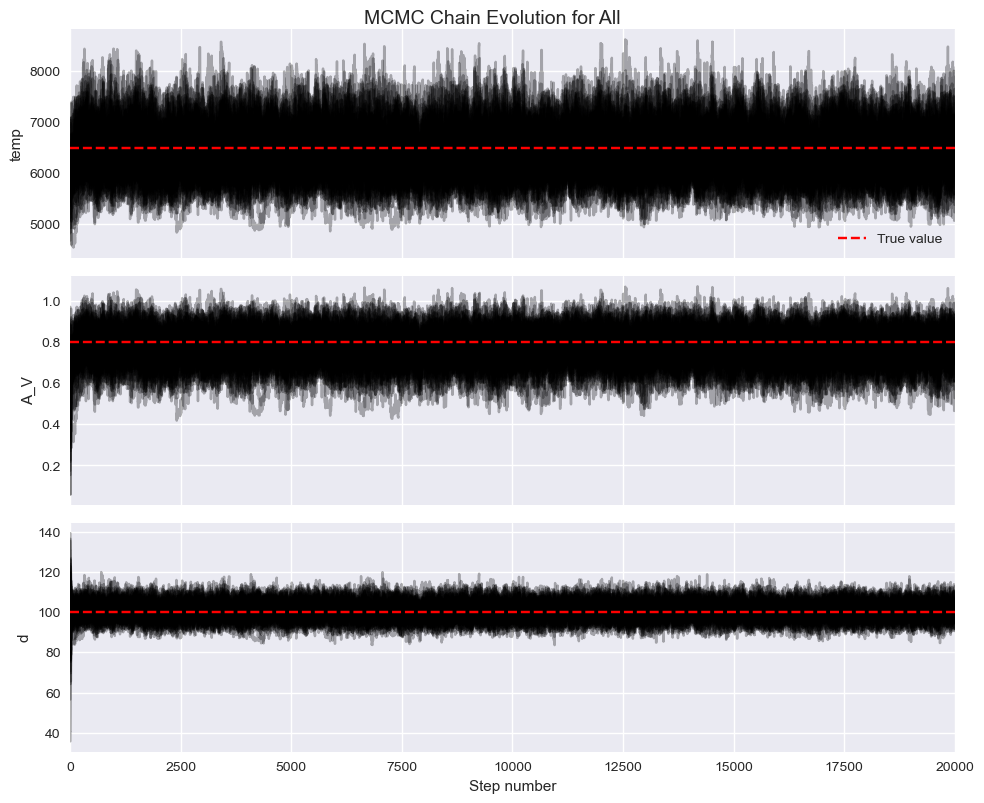


Autocorrelation times:
  temp: 138.7 steps
  A_V: 137.8 steps
  d: 123.7 steps

Recommended burn-in: 277 steps
Recommended thinning: every 61 steps
Total posterior samples: 16150

PARAMETER ESTIMATES FOR All

temp:
  True value:     6500.000
  MCMC estimate:  6393.035 +530.591 -490.487
  Difference:     106.965

A_V:
  True value:     0.800
  MCMC estimate:  0.777 +0.084 -0.092
  Difference:     0.023

d:
  True value:     100.000
  MCMC estimate:  100.482 +4.503 -4.403
  Difference:     0.482

Running MCMC for RIJHK...


100%|██████████| 20000/20000 [00:43<00:00, 460.88it/s]



Done!

Mean acceptance fraction: 0.617


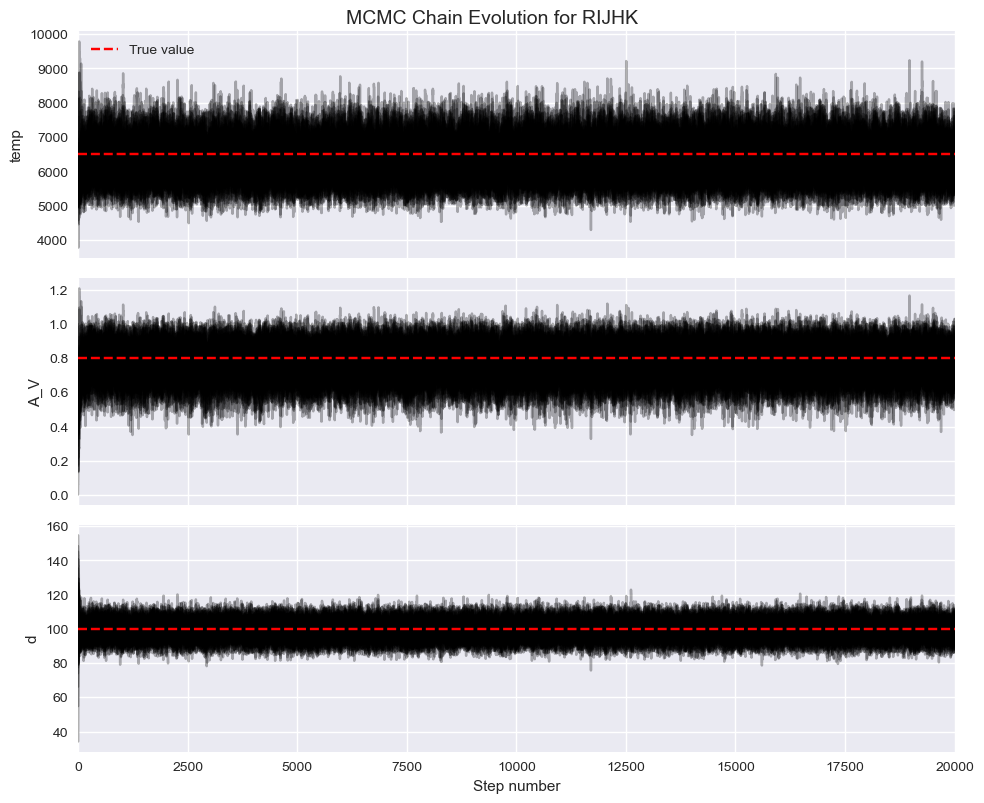


Autocorrelation times:
  temp: 55.8 steps
  A_V: 54.8 steps
  d: 52.1 steps

Recommended burn-in: 111 steps
Recommended thinning: every 26 steps
Total posterior samples: 38200

PARAMETER ESTIMATES FOR RIJHK

temp:
  True value:     6500.000
  MCMC estimate:  6324.910 +537.619 -498.445
  Difference:     175.090

A_V:
  True value:     0.800
  MCMC estimate:  0.780 +0.087 -0.093
  Difference:     0.020

d:
  True value:     100.000
  MCMC estimate:  99.305 +4.902 -4.875
  Difference:     0.695

Running MCMC for BVRIJ...


100%|██████████| 20000/20000 [00:44<00:00, 452.63it/s]



Done!

Mean acceptance fraction: 0.512


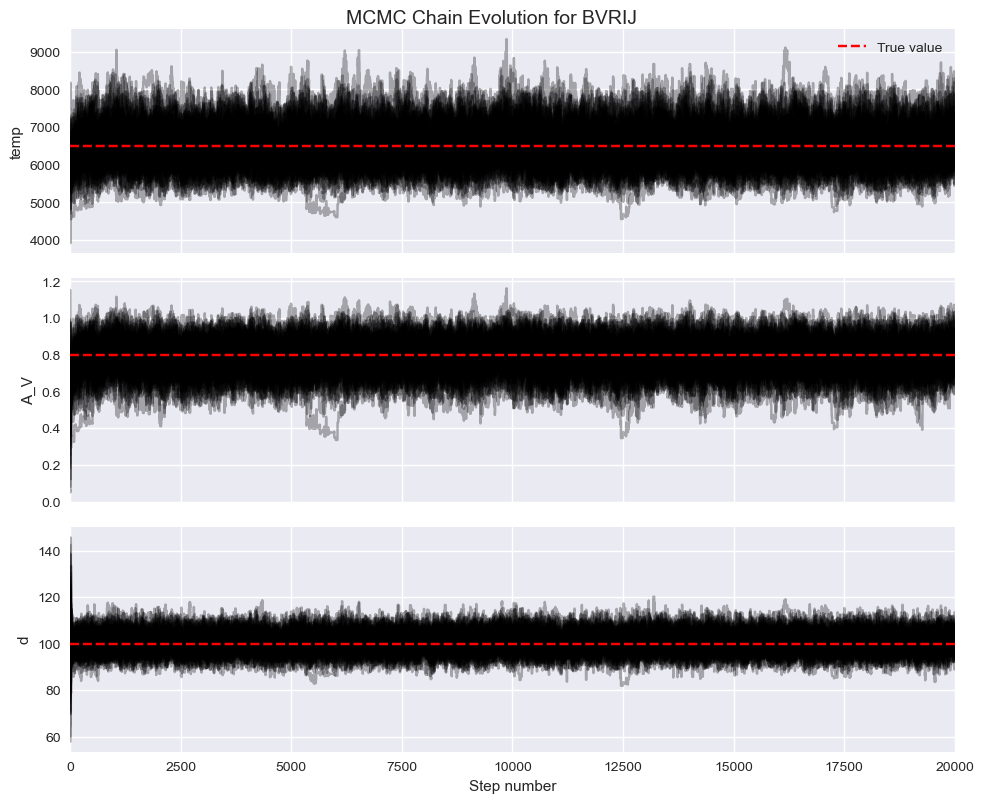


Autocorrelation times:
  temp: 166.3 steps
  A_V: 168.8 steps
  d: 136.2 steps

Recommended burn-in: 337 steps
Recommended thinning: every 68 steps
Total posterior samples: 14450

PARAMETER ESTIMATES FOR BVRIJ

temp:
  True value:     6500.000
  MCMC estimate:  6465.246 +586.211 -528.646
  Difference:     34.754

A_V:
  True value:     0.800
  MCMC estimate:  0.793 +0.094 -0.102
  Difference:     0.007

d:
  True value:     100.000
  MCMC estimate:  100.475 +4.499 -4.431
  Difference:     0.475



In [17]:
import emcee
from chainconsumer import Chain
from chainconsumer import ChainConsumer
import pandas as pd

filter_sets = {"All": filter_names, "RIJHK": ["R", "I", "J", "H", "K"], "BVRIJ": ["B", "V", "R", "I", "J"]}
c = ChainConsumer()

for name, set in filter_sets.items():
    ndim = 3  # Number of parameters
    nwalkers = 50  # Number of walkers
    nsteps = 20000  # Number of steps per walker

    # Initial positions: add small random scatter around a guess
    initial_guess = np.array([6000, 0.5, 100]) 
    pos = initial_guess + np.column_stack([500*np.random.randn(nwalkers), 0.2*np.random.randn(nwalkers), 20*np.random.randn(nwalkers)])

    # Initialize the sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, 
        args=(synthetic_star, set)
    )

    # Run MCMC
    print(f"Running MCMC for {name}...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    print("\nDone!")

    # Get the acceptance fraction
    print(f"\nMean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

    # Plot the chains
    samples = sampler.get_chain()
    labels = ["temp", "A_V", "d"]

    fig, axes = plt.subplots(3, figsize=(10, 8), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.axhline(y=[TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE][i], 
                color='r', linestyle='--', label='True value')
        if i == 0:
            ax.legend()

    axes[-1].set_xlabel("Step number")
    plt.tight_layout()
    plt.suptitle(f'MCMC Chain Evolution for {name}', y=1.002, fontsize=14)
    plt.show()

    # Calculate autocorrelation time
    try:
        tau = sampler.get_autocorr_time(tol = 0.2)
        print("\nAutocorrelation times:")
        for i, label in enumerate(labels):
            print(f"  {label}: {tau[i]:.1f} steps")
        
        burnin = int(2 * np.max(tau))
        thin = int(0.5 * np.min(tau))
        print(f"\nRecommended burn-in: {burnin} steps")
        print(f"Recommended thinning: every {thin} steps")
    except emcee.autocorr.AutocorrError:
        print("\nWarning: Chains may not have converged yet.")
        burnin = 1000
        thin = 15
        print(f"Using default burn-in: {burnin} steps")
        print(f"Using default thinning: every {thin} steps")
    flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
    df_flat_samples = pd.DataFrame(flat_samples, columns = ["Temp", "A_V", "d"])
    chain = Chain(samples= df_flat_samples, parameters = ["Temp", "A_V", "d"], name = name)
    c.add_chain(chain)


    print(f"Total posterior samples: {len(flat_samples)}")

    # Calculate parameter estimates
    print("\n" + "="*60)
    print(f"PARAMETER ESTIMATES FOR {name}")
    print("="*60)

    true_values = [TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE]
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        
        print(f"\n{labels[i]}:")
        print(f"  True value:     {true_values[i]:.3f}")
        print(f"  MCMC estimate:  {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")
        print(f"  Difference:     {abs(mcmc[1] - true_values[i]):.3f}")

    print("\n" + "="*60)

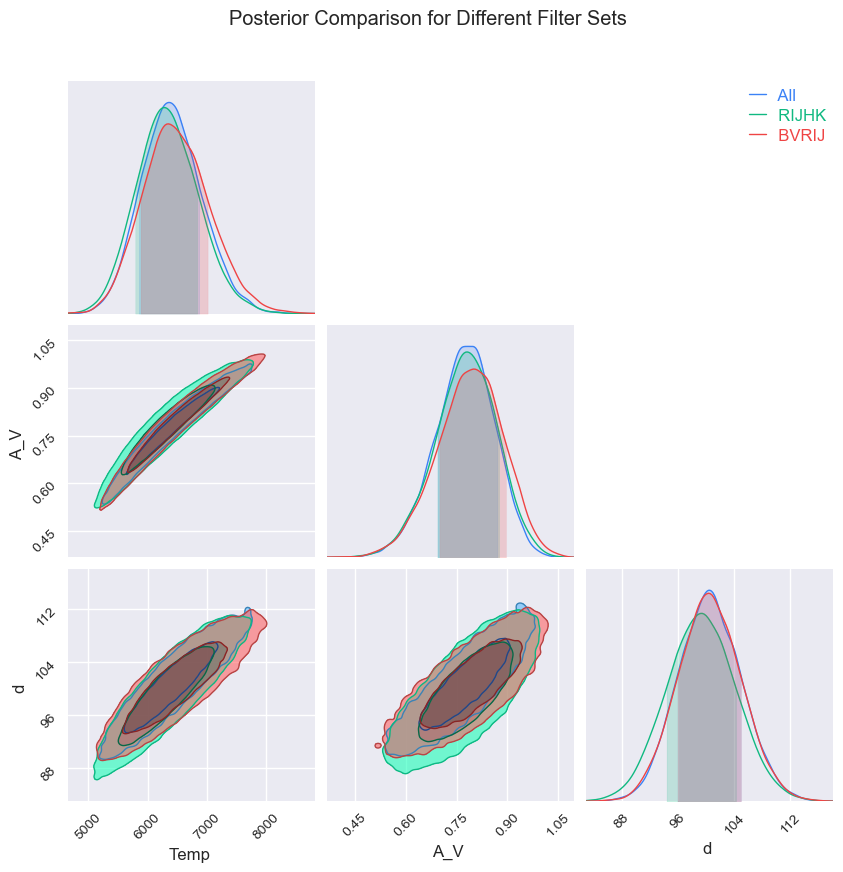

In [18]:
fig = c.plotter.plot()
plt.suptitle("Posterior Comparison for Different Filter Sets")
plt.show()

These results show the high correlation between all of the parameters, especially temperature and A_V. With fewer bands, the extinction and temperature decrease slightly, as compared to all bands. These results are pretty consistent with the results from Q2/Q3, with the same parameters being correlated and the results from different filters showing the same distribution shapes, just with different amplitudes. This analysis appears more robust and accurate than Q3's (especially for the temperature parameter- the bias is much smaller in Q4). 